In [1]:
# List of Imports
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import geopandas as gpd
import pandana as pdna
from pandana.loaders import osm
from shapely.geometry import Point

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load Network saved data
store = pd.HDFStore('./data/portugal', 'r')
nodes = store.nodes
edges = store.edges

This is a long routine to generate a new Node_DF in geodataframe, to create the Sjoin with the SubSection Polygons

In [3]:
def generate_points(row):
    point = Point(row.x, row.y)
    return point

nodes['geometry'] = nodes.apply(lambda row: generate_points(row), axis=1)

In [4]:
#  Old and very slow code...
# listOfPoints = []
# for e in nodes.iterrows():
#     point = Point(e[1].x, e[1].y)
#     listOfPoints.append(point)
# nodes['geometry'] = listOfPoints

In [5]:
nodes = gpd.GeoDataFrame(nodes)

In [6]:
# Load data Polygons
polygons = gpd.read_file('./data/BGRI_2011/CONTINENTE/BGRI11_CONT.shp', dtype={'BGRI11': str})

# Add a column with all centroids
polygons = polygons.to_crs({'init': 'epsg:4326'})
polygons['sCentroid'] = polygons.centroid

In [7]:
# Identify every node with the respective subsection BGRI11 
nodes = gpd.sjoin(nodes, polygons[['BGRI11', 'geometry']], how='left', op='intersects')

In [8]:
# Load and preprocess the network
maxDistance = 2000
network = pdna.Network(nodes.x,
                       nodes.y,
                       edges['from'], 
                       edges['to'],
                       edges[['dist']])
network.precompute(maxDistance)

In [9]:
# Load Schools Data
schoolsNetwork = gpd.read_file('./data/escolas_portugal/Escolas_EB1_2019_2.shp')

# Select only the schools with primary education
schoolsNetwork = schoolsNetwork[schoolsNetwork['ENSINOS'].str.contains('B')]

# convert coordinates data from schools
schoolsNetwork = schoolsNetwork.to_crs({'init': 'epsg:4326'})

In [10]:
# Break the X and Y from the schools Networks - Verificar esse código
schoolX = []
schoolY = []
for e in schoolsNetwork.iterrows():
    schoolX.append(e[1][20].x)
    schoolY.append(e[1][20].y)
schoolsNetwork['schoolX'] = schoolX
schoolsNetwork['schoolY'] = schoolY

In [11]:
# Set the pois with the X and Y
network.set_pois('school', maxDistance, 3, schoolsNetwork['schoolX'], schoolsNetwork['schoolY'])

# Create the Accessbility Dataframe
a = network.nearest_pois(maxDistance, "school", num_pois=3)

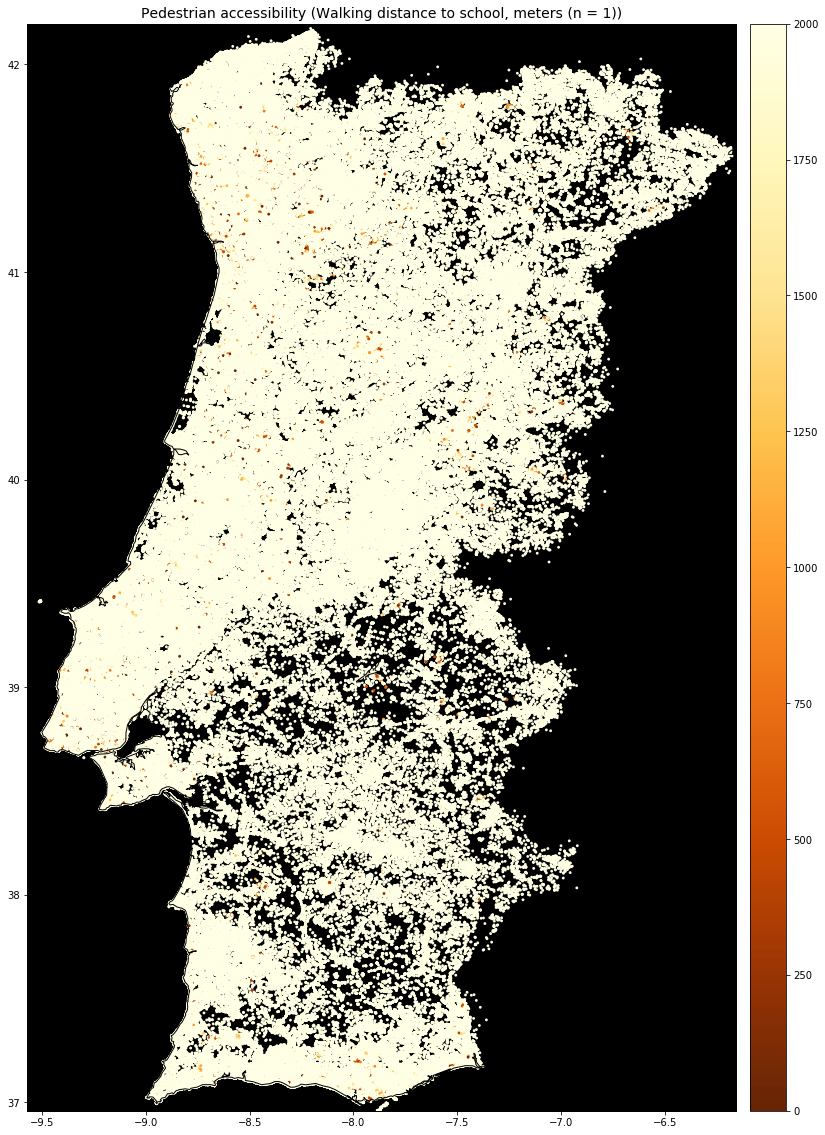

In [12]:
bbox = [-9.5725,36.9595,-6.1557,42.1967]
bbox = [bbox[1], bbox[0], bbox[3], bbox[2]]
def plot_nearest_amenity(amenity,accessibility, n):
    fig_kwargs = {'figsize': [20, 20]}
    bmap_kwargs = {'suppress_ticks': False, 'resolution': 'h', 'epsg': '4326'}
    plot_kwargs = {'cmap': 'YlOrBr_r', 's': 8, 'edgecolor': 'none'}
    bmap,fig, ax = network.plot(accessibility[n], bbox=bbox,
                               fig_kwargs=fig_kwargs, bmap_kwargs=bmap_kwargs, plot_kwargs=plot_kwargs)
    ax.set_facecolor('k')
    ax.set_title('Pedestrian accessibility (Walking distance to {}, meters (n = {}))'.format(amenity,n), fontsize=14);

plot_nearest_amenity('school',a,1)

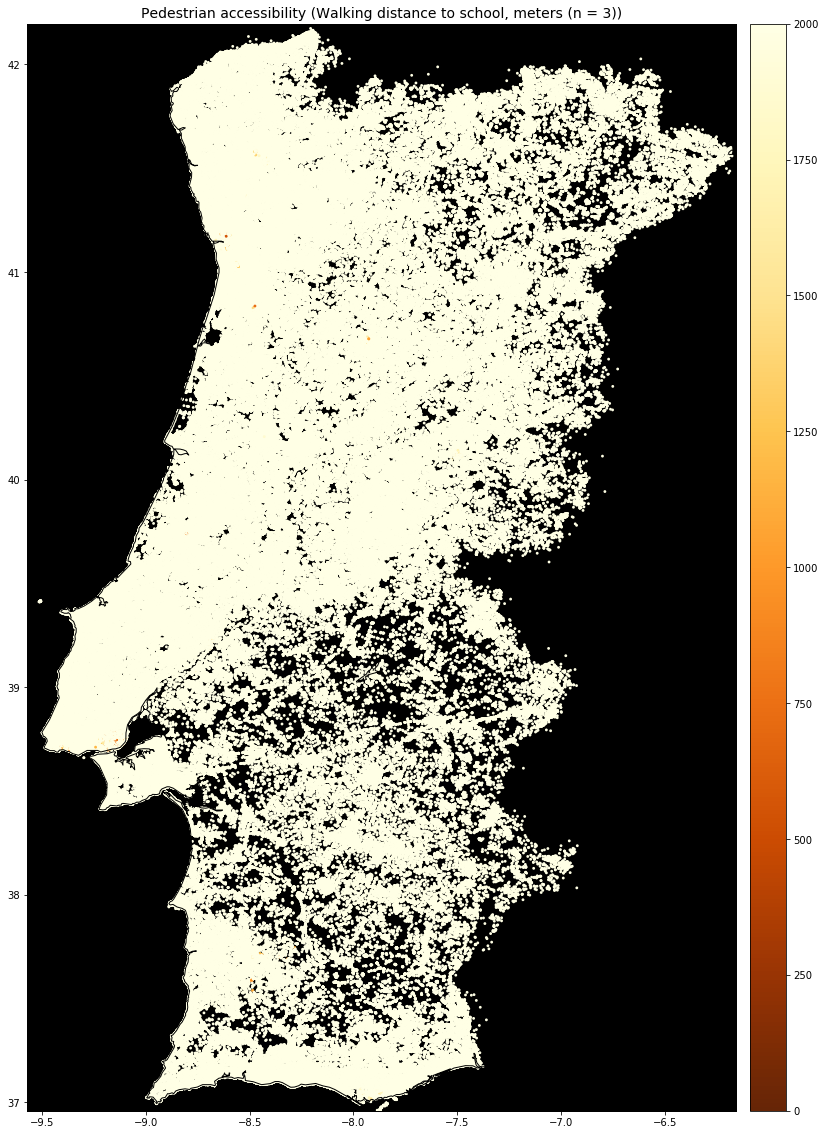

In [13]:
plot_nearest_amenity('school',a,3)

In [16]:
# Remove residual data from Polygons
polygons = polygons[polygons['LUG11DESIG']!='Residual']

In [17]:
# Load IQ data
iq_bgri = pd.read_excel('./data/qi_portugal.xlsx', dtype={'BGRI11':str})

In [18]:
# Merge data From the Nodes DF to get the Points BGRI11 reference
a = pd.merge(a, nodes[['BGRI11','geometry']], how='left', left_on=[a.index], right_on = [nodes.index])
# Clean accessibility dataframe
a = a.drop(columns=['key_0'])

In [19]:
# Calculate mean for all points grouped by BGRI11
meanDf = a.groupby(['BGRI11']).mean()

In [20]:
resultDf = pd.merge(meanDf, iq_bgri[['IQ']], how='left', left_on=[meanDf.index], right_on=[iq_bgri.BGRI11])

In [21]:
resultDf.head()

,key_0,1,2,3,IQ
0,01010100101,2000.0,2000.0,2000.0,6.285714
1,01010100103,2000.0,2000.0,2000.0,6.000000
2,01010100108,2000.0,2000.0,2000.0,3.888889
3,01010100109,2000.0,2000.0,2000.0,5.000000
4,01010100111,2000.0,2000.0,2000.0,9.000000


In [23]:
# Column name manipulation to plot data
resultDf = resultDf.rename(columns={1:'accessN1'})
resultDf.index = resultDf.key_0
resultDf = resultDf.drop(columns='key_0')

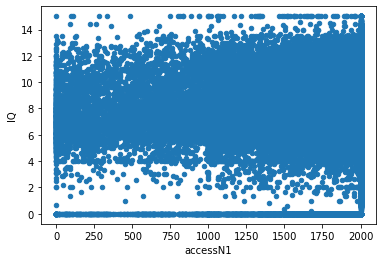

In [24]:
# Plot results
resultDf.plot(kind='scatter', x='accessN1', y ='IQ')